In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load CSV
df = pd.read_csv("/content/ADuncanWoods_NDVI_mean_2018_2025_fixed.csv")

In [ ]:
# Replace -9999 and empty with NaN
df['NDVI_mean'] = df['NDVI_mean'].replace(-9999, np.nan)

In [ ]:
# Compute NDVI min and max from valid values
ndvi_min = df['NDVI_mean'].min()
ndvi_max = df['NDVI_mean'].max()

In [ ]:
# Calculate FHI
df['FHI'] = (df['NDVI_mean'] - ndvi_min) / (ndvi_max - ndvi_min)

In [ ]:
# Clip values between 0 and 1
df['FHI'] = df['FHI'].clip(0, 1)

In [ ]:
# Save to new CSV
df.to_csv("DuncanWoods_FHI_2018_2025.csv", index=False)

In [ ]:
print("NDVI min:", ndvi_min, "NDVI max:", ndvi_max)
print(df.head())

NDVI min: -0.0395021874388629 NDVI max: 0.9920597863668804
             system:index  NDVI_mean  cell_id     date  id  \
0  0_00000000000000000000        NaN        1  2018-01   1   
1  0_00000000000000000001        NaN        2  2018-01   1   
2  0_00000000000000000002        NaN        3  2018-01   1   
3  0_00000000000000000003        NaN        4  2018-01   1   
4  0_00000000000000000004        NaN        5  2018-01   1   

                                                .geo  FHI  
0  {"type":"Polygon","coordinates":[[[-86.2449535...  NaN  
1  {"type":"Polygon","coordinates":[[[-86.2449535...  NaN  
2  {"type":"Polygon","coordinates":[[[-86.2451785...  NaN  
3  {"type":"Polygon","coordinates":[[[-86.2453912...  NaN  
4  {"type":"Polygon","coordinates":[[[-86.2455857...  NaN  


In [ ]:
import pandas as pd
import numpy as np

# ==== 1. Load NDVI CSV ====
df = pd.read_csv("/content/ADuncanWoods_NDVI_mean_2018_2025_fixed.csv")

# Replace -9999 and blanks with NaN
df['NDVI_mean'] = pd.to_numeric(df['NDVI_mean'], errors='coerce')
df['NDVI_mean'] = df['NDVI_mean'].replace(-9999, np.nan)

# ==== 2. Normalize NDVI ====
ndvi_min = df['NDVI_mean'].min(skipna=True)
ndvi_max = df['NDVI_mean'].max(skipna=True)
df['NDVI_norm'] = (df['NDVI_mean'] - ndvi_min) / (ndvi_max - ndvi_min)

# ==== 3. Add Canopy Height (typical values from GEDI literature) ====
# Here: assume 25 m healthy height for all cells (as a placeholder)
# Replace with your own per-cell data if available
df['Canopy_height_m'] = 25

# Normalize height (min=0, max=35 m typical for temperate forests)
df['Height_norm'] = (df['Canopy_height_m'] - 0) / (35 - 0)

# ==== 4. Add Canopy Cover (%) ====
# Assume 80% healthy cover for all cells (placeholder)
df['Canopy_cover_pct'] = 80

# Normalize cover (min=0%, max=100%)
df['Cover_norm'] = (df['Canopy_cover_pct'] - 0) / (100 - 0)

# ==== 5. Compute FHI ====
# Equal weights
w1, w2, w3 = 1/3, 1/3, 1/3
df['FHI'] = w1*df['NDVI_norm'] + w2*df['Height_norm'] + w3*df['Cover_norm']

# ==== 6. Save output ====
df.to_csv("/content/DuncanWoods_FHI_multi_metric.csv", index=False)

print("NDVI range:", ndvi_min, "to", ndvi_max)
print(df[['cell_id', 'date', 'NDVI_mean', 'NDVI_norm', 'Height_norm', 'Cover_norm', 'FHI']].head())


NDVI range: -0.0395021874388629 to 0.9920597863668804
   cell_id     date  NDVI_mean  NDVI_norm  Height_norm  Cover_norm  FHI
0        1  2018-01        NaN        NaN     0.714286         0.8  NaN
1        2  2018-01        NaN        NaN     0.714286         0.8  NaN
2        3  2018-01        NaN        NaN     0.714286         0.8  NaN
3        4  2018-01        NaN        NaN     0.714286         0.8  NaN
4        5  2018-01        NaN        NaN     0.714286         0.8  NaN


In [ ]:
import pandas as pd
import numpy as np

# ==== 1. Load multi-metric FHI CSV ====
df = pd.read_csv("/content/DuncanWoods_FHI_multi_metric.csv")

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# ==== 2. Compute yearly NDVI std per cell_id ====
df['year'] = df['date'].dt.year

# Group by cell_id and year
ndvi_std_yearly = (
    df.groupby(['cell_id', 'year'])['NDVI_mean']
      .std()
      .reset_index()
      .rename(columns={'NDVI_mean': 'NDVI_std'})
)

# ==== 3. Normalize stability (lower std = higher stability) ====
std_min = ndvi_std_yearly['NDVI_std'].min(skipna=True)
std_max = ndvi_std_yearly['NDVI_std'].max(skipna=True)

# Stability score = inverted normalized std
ndvi_std_yearly['Stability_norm'] = 1 - (
    (ndvi_std_yearly['NDVI_std'] - std_min) / (std_max - std_min)
)
ndvi_std_yearly['Stability_norm'] = ndvi_std_yearly['Stability_norm'].clip(0, 1)

# ==== 4. Merge stability back to main DataFrame ====
df = df.merge(ndvi_std_yearly[['cell_id', 'year', 'Stability_norm']],
              on=['cell_id', 'year'], how='left')

# ==== 5. Compute final FHI including stability ====
# Equal weights for NDVI_norm, Height_norm, Cover_norm, Stability_norm
w1 = w2 = w3 = w4 = 0.25
df['FHI_final'] = (
    w1 * df['NDVI_norm'] +
    w2 * df['Height_norm'] +
    w3 * df['Cover_norm'] +
    w4 * df['Stability_norm']
)

# ==== 6. Save output ====
df.to_csv("/content/DuncanWoods_FHI_with_stability.csv", index=False)

print(df[['cell_id', 'date', 'NDVI_mean', 'NDVI_norm', 'Height_norm', 'Cover_norm', 'Stability_norm', 'FHI_final']].head())


   cell_id       date  NDVI_mean  NDVI_norm  Height_norm  Cover_norm  \
0        1 2018-01-01        NaN        NaN     0.714286         0.8   
1        2 2018-01-01        NaN        NaN     0.714286         0.8   
2        3 2018-01-01        NaN        NaN     0.714286         0.8   
3        4 2018-01-01        NaN        NaN     0.714286         0.8   
4        5 2018-01-01        NaN        NaN     0.714286         0.8   

   Stability_norm  FHI_final  
0        0.481063        NaN  
1        0.497322        NaN  
2        0.180769        NaN  
3        0.159257        NaN  
4        0.140137        NaN  


/tmp/ipython-input-1031038542.py:121: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  latest.plot(column='Health_Class',


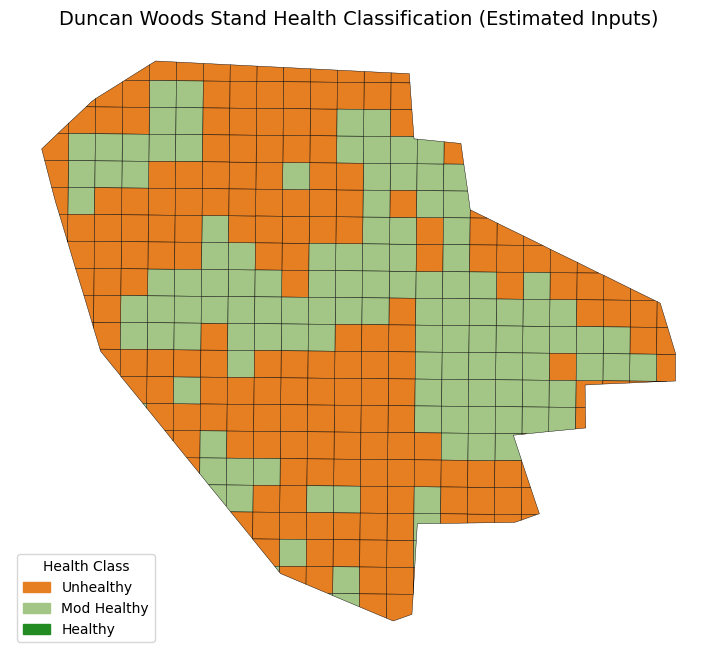

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from shapely.geometry import shape
import matplotlib.pyplot as plt

# ==== 1. Load CSV ====
df = pd.read_csv("/content/DuncanWoods_FHI_with_stability.csv")

# ==== 2. Prepare NDVI & height ====
df['NDVI_mean'] = pd.to_numeric(df['NDVI_mean'], errors='coerce')
# df['date'] = pd.to_datetime(df['date'], format='%Y-%m') # Remove redundant conversion

# Assume canopy height from Height_norm (max height = 35 m)
df['Canopy_Height_m'] = df['Height_norm'] * 35

# ==== 3. Derive LAI from NDVI (Garrigues et al., 2008) ====
df['LAI'] = 3.618 * df['NDVI_mean'] - 0.118
df['LAI'] = df['LAI'].clip(lower=0)  # avoid negatives

# ==== 4. Estimate LCR from canopy cover ====
# If canopy cover ≥ 80% → LCR = 40%
# If 60–80% → 35%, else 30%
def estimate_lcr(cov):
    if cov >= 80:
        return 0.40
    elif cov >= 60:
        return 0.35
    else:
        return 0.30

df['LCR'] = df['Canopy_cover_pct'].apply(estimate_lcr)

# ==== 5. Estimate SDI from height ====
def estimate_sdi(h):
    if h < 18:
        return 350
    elif h <= 30:
        return 200
    else:
        return 150

df['SDI'] = df['Canopy_Height_m'].apply(estimate_sdi)

# ==== 6. Apply Das (2024) decision tree ====
def classify_health(row):
    H = row['Canopy_Height_m']
    SDI = row['SDI']
    LCR = row['LCR']
    LAI = row['LAI']

    # Height < 18 m
    if H < 18:
        if SDI < 365:
            if LCR >= 0.40:
                return 'Unhealthy' if LAI < 3 else 'Mod Healthy'
            else:
                if LAI > 3:
                    if LAI < 1.5:
                        return 'Unhealthy'
                    elif LAI < 3:
                        return 'Mod Healthy'
                    else:
                        return 'Healthy'
                else:
                    return 'Unhealthy'
    # Height 18–30 m
    elif H <= 30:
        if SDI < 225:
            if LCR >= 0.35:
                return 'Unhealthy' if LAI < 3 else 'Mod Healthy'
            else:
                if LAI > 3:
                    if LAI < 1.5:
                        return 'Unhealthy'
                    elif LAI < 3:
                        return 'Mod Healthy'
                    else:
                        return 'Healthy'
                else:
                    return 'Unhealthy'
    # Height > 30 m
    else:
        if SDI < 160:
            if LCR >= 0.30:
                return 'Unhealthy' if LAI < 3 else 'Mod Healthy'
            else:
                if LAI > 3:
                    if LAI < 1.5:
                        return 'Unhealthy'
                    elif LAI < 3:
                        return 'Mod Healthy'
                    else:
                        return 'Healthy'
                else:
                    return 'Unhealthy'
    return 'Unhealthy'  # fallback

df['Health_Class'] = df.apply(classify_health, axis=1)

# ==== 7. Save classified CSV ====
df.to_csv("/content/DuncanWoods_health_classification.csv", index=False)

# ==== 8. Convert to GeoDataFrame for mapping ====
df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# ==== 9. Take the latest record for each cell_id for mapping ====
latest = gdf.sort_values('date').groupby('cell_id').tail(1)

# ==== 10. Define colors like Fig. 8 ====
color_map = {
    'Unhealthy': '#e67e22',     # orange
    'Mod Healthy': '#a3c586',   # light green
    'Healthy': '#228B22'        # dark green
}

# ==== 11. Plot static map ====
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
latest.plot(column='Health_Class',
            color=latest['Health_Class'].map(color_map),
            edgecolor='black',
            linewidth=0.3,
            legend=True,
            ax=ax)

# Create legend manually
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=color_map[k], label=k) for k in color_map]
ax.legend(handles=patches, title="Health Class", loc='lower left')

ax.set_title("Duncan Woods Stand Health Classification (Estimated Inputs)", fontsize=14)
ax.axis('off')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv("/content/DuncanWoods_FHI_with_stability.csv")

# Ensure NDVI_mean is numeric and replace invalids
df['NDVI_mean'] = pd.to_numeric(df['NDVI_mean'], errors='coerce')
df['NDVI_mean'] = df['NDVI_mean'].replace(-9999, np.nan)

# ==== 1. LAI from NDVI ====
df['LAI'] = 3.618 * df['NDVI_mean'] - 0.118
df['LAI'] = df['LAI'].clip(lower=0, upper=8)  # keep within vegetation realistic limits

# ==== 2. LCR from NDVI_norm ====
ndvi_min = df['NDVI_mean'].min(skipna=True)
ndvi_max = df['NDVI_mean'].max(skipna=True)
df['NDVI_norm'] = (df['NDVI_mean'] - ndvi_min) / (ndvi_max - ndvi_min)
df['LCR'] = 20 + (df['NDVI_norm'] * 50)  # range: 20–70%

# ==== 3. SDI from canopy cover ====
# Assuming you already have Canopy_cover_pct from previous FHI calculation
# Normalize canopy cover
df['Cover_norm'] = (df['Canopy_cover_pct'] - 0) / 100
df['SDI'] = 150 + (df['Cover_norm'] * 250)  # range: 150–400

# Save updated CSV
df.to_csv("/content/DuncanWoods_with_LAI_LCR_SDI.csv", index=False)

print(df[['cell_id', 'date', 'NDVI_mean', 'LAI', 'LCR', 'SDI']].head())

   cell_id        date  NDVI_mean  LAI  LCR    SDI
0        1  2018-01-01        NaN  NaN  NaN  350.0
1        2  2018-01-01        NaN  NaN  NaN  350.0
2        3  2018-01-01        NaN  NaN  NaN  350.0
3        4  2018-01-01        NaN  NaN  NaN  350.0
4        5  2018-01-01        NaN  NaN  NaN  350.0


In [ ]:
import pandas as pd
import numpy as np

# Load CSV with LAI, LCR, SDI, Canopy_height_m
df = pd.read_csv("/content/DuncanWoods_with_LAI_LCR_SDI.csv")

# ----- Decision tree classification -----
def classify_row(row):
    h = row['Canopy_height_m']
    sdi = row['SDI']
    lcr = row['LCR']
    lai = row['LAI']

    # CASE 1: Height < 18 m
    if h < 18:
        if sdi < 365:
            if lcr >= 40:
                return 'Unhealthy' if lai < 3 else 'Mod Healthy'
        else:
            if lcr >= 40:
                if lai > 3:
                    return 'Healthy'
                elif lai < 1.5:
                    return 'Unhealthy'
                else:
                    return 'Mod Healthy'

    # CASE 2: Height 18–30 m
    elif 18 <= h <= 30:
        if sdi < 225:
            if lcr >= 35:
                return 'Unhealthy' if lai < 3 else 'Mod Healthy'
        else:
            if lcr >= 35:
                if lai > 3:
                    return 'Healthy'
                elif lai < 1.5:
                    return 'Unhealthy'
                else:
                    return 'Mod Healthy'

    # CASE 3: Height > 30 m
    else:
        if sdi < 160:
            if lcr >= 30:
                return 'Unhealthy' if lai < 3 else 'Mod Healthy'
        else:
            if lcr >= 30:
                if lai > 3:
                    return 'Healthy'
                elif lai < 1.5:
                    return 'Unhealthy'
                else:
                    return 'Mod Healthy'

    return 'Unclassified'

# Apply classification to all rows
df['Health_Class'] = df.apply(classify_row, axis=1)

# ----- Get most frequent class per cell_id -----
mode_class = (
    df.groupby('cell_id')['Health_Class']
      .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unclassified')
      .reset_index()
      .rename(columns={'Health_Class': 'Final_Health_Class'})
)

# Merge back into one row per cell_id with geometry
# Take first row per cell_id to keep .geo
final_df = df.groupby('cell_id').first().reset_index()
final_df = final_df[['cell_id', '.geo']].merge(mode_class, on='cell_id')

# ----- Add Kepler color codes -----
color_map = {
    'Unhealthy': '#FFA500',      # orange
    'Mod Healthy': '#90EE90',    # light green
    'Healthy': '#006400',        # dark green
    'Unclassified': '#808080'    # gray
}
final_df['Color'] = final_df['Final_Health_Class'].map(color_map)

# Save for Kepler
final_df.to_csv("/content/DuncanWoods_Kepler_HealthClass.csv", index=False)

print(final_df.head())

   cell_id                                               .geo  \
0        1  {"type":"Polygon","coordinates":[[[-86.2449535...   
1        2  {"type":"Polygon","coordinates":[[[-86.2449535...   
2        3  {"type":"Polygon","coordinates":[[[-86.2451785...   
3        4  {"type":"Polygon","coordinates":[[[-86.2453912...   
4        5  {"type":"Polygon","coordinates":[[[-86.2455857...   

  Final_Health_Class    Color  
0          Unhealthy  #FFA500  
1       Unclassified  #808080  
2        Mod Healthy  #90EE90  
3        Mod Healthy  #90EE90  
4        Mod Healthy  #90EE90  


In [ ]:
import pandas as pd

# Load the CSV file
file_path = "/content/DuncanWoods_with_LAI_LCR_SDI.csv"
df = pd.read_csv(file_path)

# Filter only rows that have LAI, LCR, and SDI values
df_filtered = df.dropna(subset=['LAI', 'LCR', 'SDI'])

# Step 1: Normalize LAI, LCR, SDI using Min-Max normalization to 0–1
for col in ['LAI', 'LCR', 'SDI']:
    min_val = df_filtered[col].min()
    max_val = df_filtered[col].max()
    df_filtered[f'{col}_norm'] = (df_filtered[col] - min_val) / (max_val - min_val)

# Step 2: Apply weights as per Das (2024) — assuming equal weights since exact ones are not given in the excerpt
w_LAI, w_LCR, w_SDI = 1/3, 1/3, 1/3

# Step 3: Compute SHI in range 0–1 first
df_filtered['SHI_norm'] = (w_LAI * df_filtered['LAI_norm'] +
                           w_LCR * df_filtered['LCR_norm'] +
                           w_SDI * df_filtered['SDI_norm'])

# Step 4: Scale SHI to 1.5–5 range
min_scale, max_scale = 1.5, 5
df_filtered['SHI'] = min_scale + df_filtered['SHI_norm'] * (max_scale - min_scale)

# Merge back into original dataframe
df = df.merge(df_filtered[['system:index', 'SHI']], on='system:index', how='left')

# Save new CSV
output_path = "/content/DuncanWoods_with_SHI.csv"
df.to_csv(output_path, index=False)

output_path


/tmp/ipython-input-954402373.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'{col}_norm'] = (df_filtered[col] - min_val) / (max_val - min_val)
/tmp/ipython-input-954402373.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'{col}_norm'] = (df_filtered[col] - min_val) / (max_val - min_val)
/tmp/ipython-input-954402373.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

'/content/DuncanWoods_with_SHI.csv'

**Categorization based on the FHI Value**

Compute the mean (µ) and SD (σ) of FHI. Define categories like- Healthy: ≥ µ + 1σ Moderately Healthy: between µ and µ + 1σ Slightly Stressed: between µ − 1σ and µ Stressed: ≤ µ − 1σ For 5–6 classes, add extra bins at ±0.5σ or ±1.5σ.

In [2]:
pip install caas_jupyter_tools

ERROR: Could not find a version that satisfies the requirement caas_jupyter_tools (from versions: none)
ERROR: No matching distribution found for caas_jupyter_tools


In [4]:
# This script reads the user's CSV, finds an FHI-like column, computes SD-based thresholds,
# applies 5- and 6-class categorizations with an explicit rule that FHI < 0.4 == at least "Stressed",
# and saves an updated CSV with two new columns.
#
# It also shows a small preview of the updated dataframe to the user.

import os
import pandas as pd
import numpy as np
# from caas_jupyter_tools import display_dataframe_to_user # Removed due to ModuleNotFoundError
from IPython.display import display # Use standard display

# ---- CONFIG ----
INPUT_PATH = "/content/DuncanWoods_with_LAI_LCR_SDI.csv"
OUTPUT_PATH = "/content/DuncanWoods_with_FHI_classes.csv"

# ---- LOAD ----
df = pd.read_csv(INPUT_PATH)

# ---- Locate an FHI column or construct a fallback ----
# Try common FHI column names
candidates = [
    "FHI", "fhi", "Forest_Health_Index", "forest_health_index",
    "FHI_value", "FHI_score", "ForestHealthIndex"
]
fhi_col = None
for c in candidates:
    if c in df.columns:
        fhi_col = c
        break

# If not found, try to infer from similar names
if fhi_col is None:
    for c in df.columns:
        if "fhi" in c.lower():
            fhi_col = c
            break

# If still not found, build a very simple proxy (best-effort) from positive indicators if present.
# NOTE: This proxy is *only* used if no explicit FHI column exists.
if fhi_col is None:
    pos_cols = [c for c in df.columns if c.upper() in {"LAI", "LCR"}]
    # Optional canopy height as weak positive signal
    if "Canopy_height_m" in df.columns:
        pos_cols.append("Canopy_height_m")
    if len(pos_cols) > 0:
        # Normalize each positive column to 0-1 and average
        normed = []
        for c in pos_cols:
            col = df[c].astype(float)
            rng = col.max() - col.min()
            if rng == 0:
                normed.append(np.zeros_like(col, dtype=float))
            else:
                normed.append((col - col.min()) / rng)
        proxy = np.mean(np.vstack(normed), axis=0)
        df["_FHI_proxy"] = proxy
        fhi_col = "_FHI_proxy"
    else:
        # If absolutely nothing is available, make a constant (degenerate) FHI
        df["_FHI_proxy"] = 0.5
        fhi_col = "_FHI_proxy"

# ---- Create updated_FHI ----
# Clip to [0, 1] range as a common convention; if original looks already in [0,1] this is a no-op.
updated_FHI = pd.to_numeric(df[fhi_col], errors="coerce").astype(float)
updated_FHI = updated_FHI.clip(lower=0, upper=1)
df["updated_FHI"] = updated_FHI

# ---- Compute statistics ----
mu = float(updated_FHI.mean(skipna=True))
sigma = float(updated_FHI.std(ddof=0, skipna=True))

# Handle edge case: zero variance
if sigma == 0 or np.isnan(sigma):
    # Fall back to quantile-based bins to avoid division-by-zero
    q = updated_FHI.quantile([0.1, 0.3, 0.5, 0.7, 0.9]).to_dict()
    def classify_quantile(x):
        if pd.isna(x):
            return "Unknown"
        if x < 0.4:  # explicit rule
            return "Stressed"
        if x <= q[0.1]:
            return "Severely Stressed"
        elif x <= q[0.3]:
            return "Stressed"
        elif x <= q[0.5]:
            return "Slightly Stressed"
        elif x <= q[0.7]:
            return "Moderately Healthy"
        else:
            return "Healthy"
    df["FHI_class_5bin"] = updated_FHI.apply(classify_quantile)

    # 6-class version using more breakpoints
    q6 = updated_FHI.quantile([0.05, 0.2, 0.4, 0.6, 0.8]).to_dict()
    def classify_quantile_6(x):
        if pd.isna(x):
            return "Unknown"
        if x < 0.4:  # at least Stressed
            if x <= q6[0.05]:
                return "Severely Stressed"
            elif x <= q6[0.2]:
                return "Stressed"
            else:
                return "Slightly Stressed"
        # Healthy side
        if x <= q6[0.4]:
            return "Slightly Stressed"
        elif x <= q6[0.6]:
            return "Moderately Healthy"
        elif x <= q6[0.8]:
            return "Healthy"
        else:
            return "Very Healthy"
    df["FHI_class_6bin"] = updated_FHI.apply(classify_quantile_6)

else:
    # ---- Thresholds for SD-based classes ----
    # 5-class bins focusing on stressed:
    # Severely Stressed: <= min(mu - 1.5σ, 0.4)
    # Stressed: (min(mu - 1.5σ, 0.4), mu - 1σ]
    # Slightly Stressed: (mu - 1σ, mu]
    # Moderately Healthy: (mu, mu + 1σ]
    # Healthy: > mu + 1σ
    t_m15 = mu - 1.5 * sigma
    t_m1  = mu - 1.0 * sigma
    t_p1  = mu + 1.0 * sigma

    severe_cut = min(t_m15, 0.4)  # enforce FHI<0.4 as at least stressed; severe picks the stricter
    def classify_5(x):
        if pd.isna(x):
            return "Unknown"
        # Hard rule: if FHI < 0.4 -> at least Stressed
        if x < 0.4 and x > severe_cut:
            # Between 0.4 rule and severe_cut; this happens if severe_cut < 0.4
            return "Stressed"
        if x <= severe_cut:
            return "Severely Stressed"
        elif x <= t_m1:
            return "Stressed"
        elif x <= mu:
            return "Slightly Stressed"
        elif x <= t_p1:
            return "Moderately Healthy"
        else:
            return "Healthy"

    df["FHI_class_5bin"] = updated_FHI.apply(classify_5)

    # 6-class bins using ±0.5σ and ±1.5σ as suggested
    t_m05 = mu - 0.5 * sigma
    t_p05 = mu + 0.5 * sigma
    t_p15 = mu + 1.5 * sigma

    def classify_6(x):
        if pd.isna(x):
            return "Unknown"
        # Hard rule: enforce FHI < 0.4 => at least Stressed
        if x < 0.4:
            # Further split stressed side using 1.5σ threshold where possible
            if x <= min(t_m15, 0.35):  # a bit stricter for "severe"
                return "Severely Stressed"
            elif x <= t_m1:
                return "Stressed"
            else:
                return "Slightly Stressed"
        # Healthy side with 0.5σ and 1.5σ
        if x <= t_m05:
            return "Slightly Stressed"
        elif x <= mu:
            return "Near Neutral"
        elif x <= t_p05:
            return "Moderately Healthy"
        elif x <= t_p1:
            return "Healthy"
        else:
            return "Very Healthy"

    df["FHI_class_6bin"] = updated_FHI.apply(classify_6)

# ---- Save ----
df.to_csv(OUTPUT_PATH, index=False)

# ---- Show a small preview & where to download ----
preview_cols = [c for c in ["updated_FHI", "FHI_class_5bin", "FHI_class_6bin"] if c in df.columns]
preview = df[preview_cols].head(20) if preview_cols else df.head(20)
# display_dataframe_to_user("Preview of updated FHI classes", preview) # Removed due to ModuleNotFoundError
print("Preview of updated FHI classes:")
display(preview) # Use standard display

OUTPUT_PATH

Preview of updated FHI classes:


,updated_FHI,FHI_class_5bin,FHI_class_6bin
0,NaN,Unknown,Unknown
1,NaN,Unknown,Unknown
2,NaN,Unknown,Unknown
3,NaN,Unknown,Unknown
4,NaN,Unknown,Unknown
5,NaN,Unknown,Unknown
6,NaN,Unknown,Unknown
7,NaN,Unknown,Unknown
8,NaN,Unknown,Unknown
9,NaN,Unknown,Unknown


'/content/DuncanWoods_with_FHI_classes.csv'

In [5]:
# fhi_categorize.py
import os
import pandas as pd
import numpy as np

# ---- CONFIG ----
INPUT_CSV  = r"/content/DuncanWoods_with_LAI_LCR_SDI.csv"
OUTPUT_CSV = os.path.splitext(INPUT_CSV)[0] + "_with_updated_FHI.csv"

# ---- HELPERS ----
def minmax_scale(series: pd.Series) -> pd.Series:
    """Safe min-max scaling to [0,1]; handles constant series."""
    s_min = series.min()
    s_max = series.max()
    if pd.isna(s_min) or pd.isna(s_max):
        raise ValueError("Series contains all-NaN values.")
    if s_max == s_min:
        # Avoid divide-by-zero: return 0.5 to keep neutral weight
        return pd.Series(np.full(len(series), 0.5), index=series.index)
    return (series - s_min) / (s_max - s_min)

def harmonic_mean(a: pd.Series, b: pd.Series, eps: float = 1e-9) -> pd.Series:
    """Element-wise harmonic mean in [0,1], robust to zeros."""
    a = a.clip(0, 1)
    b = b.clip(0, 1)
    return 2.0 / ( (1.0/(a+eps)) + (1.0/(b+eps)) )

def rescale_to_range(z01: pd.Series, orig_min: float, orig_max: float) -> pd.Series:
    """Rescales z in [0,1] to original range [orig_min, orig_max]."""
    return orig_min + z01 * (orig_max - orig_min)

# ---- LOAD ----
df = pd.read_csv(INPUT_CSV)

required_cols = ["FHI", "Stability_norm"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required column(s): {missing}. "
                   f"Make sure your CSV has {required_cols}.")

# Ensure numeric
for c in required_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows where both FHI and Stability_norm are NaN (can’t compute anything)
df = df.dropna(subset=["FHI", "Stability_norm"], how="all").copy()

# ---- UPDATED FHI (penalize low stability) ----
# 1) Normalize both to [0,1]
FHI_min, FHI_max = df["FHI"].min(), df["FHI"].max()
FHI_01           = minmax_scale(df["FHI"])
Stab_01          = minmax_scale(df["Stability_norm"])

# 2) Combine with harmonic mean to penalize low Stability more strongly
#    (If either FHI or Stability_norm is low, Updated_FHI_01 drops)
Updated_FHI_01   = harmonic_mean(FHI_01, Stab_01)

# 3) Rescale Updated_FHI back to original FHI scale for interpretability
df["Updated_FHI"] = rescale_to_range(Updated_FHI_01, FHI_min, FHI_max)

# ---- CATEGORIZATION USING μ AND σ (on Updated_FHI) ----
mu = df["Updated_FHI"].mean()
sigma = df["Updated_FHI"].std(ddof=0)  # population std; use ddof=1 if you prefer sample std

low_15  = mu - 1.5 * sigma
low_10  = mu - 1.0 * sigma
mid_00  = mu
high_10 = mu + 1.0 * sigma
high_15 = mu + 1.5 * sigma

def categorize(row):
    fhi_orig = row["FHI"]
    fhi_upd  = row["Updated_FHI"]

    # HARD RULE: if original FHI < 0.4 → "Severely Stressed"
    if pd.notna(fhi_orig) and (fhi_orig < 0.4):
        return "Severely Stressed"

    # Otherwise, use Updated_FHI thresholds
    if pd.isna(fhi_upd):
        return "Unknown"

    if fhi_upd <= low_15:
        return "Severely Stressed"
    elif fhi_upd <= low_10:
        return "Stressed"
    elif fhi_upd <= mid_00:
        return "Slightly Stressed"
    elif fhi_upd <= high_10:
        return "Moderately Healthy"
    elif fhi_upd <= high_15:
        return "Healthy"
    else:
        return "Very Healthy"

df["FHI_Category"] = df.apply(categorize, axis=1)

# ---- SAVE ----
df.to_csv(OUTPUT_CSV, index=False)

print(f"Saved: {OUTPUT_CSV}")
print("Category counts:")
print(df["FHI_Category"].value_counts(dropna=False))


Saved: /content/DuncanWoods_with_LAI_LCR_SDI_with_updated_FHI.csv
Category counts:
FHI_Category
Moderately Healthy    9813
Slightly Stressed     8277
Healthy               2674
Unknown               2478
Severely Stressed     2438
Stressed              2114
Very Healthy          1726
Name: count, dtype: int64


In [9]:
import pandas as pd
import os

# ---- CONFIG ----
INPUT_CSV  = r"/content/DuncanWoods_with_LAI_LCR_SDI_with_updated_FHI.csv"
OUTPUT_CSV = os.path.splitext(INPUT_CSV)[0] + "_June2025.csv"

# ---- LOAD & PARSE DATE ----
df = pd.read_csv(INPUT_CSV)

# Ensure Date column is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# ---- FILTER FOR JUNE 2025 ----
df_june2025 = df[(df['date'].dt.year == 2025) & (df['date'].dt.month == 6)]

# ---- SAVE ----
df_june2025.to_csv(OUTPUT_CSV, index=False)

print(f"Filtered rows: {len(df_june2025)}")
print(f"Saved to: {OUTPUT_CSV}")


Filtered rows: 328
Saved to: /content/DuncanWoods_with_LAI_LCR_SDI_with_updated_FHI_June2025.csv
